[← Previous: Dataset Comparison Analysis](05_dataset_comparison_analysis.ipynb)

# **Text Classification by DistilBERT**

**Purpose**: Explore using DistilBERT, a pretrained transformer model from Hugging Face, to classify the anxiety level (0-5 scale) for Reddit posts.

## Table of Contents

1. [Import Packages and Datasets](#1-import-packages-and-datasets)
2. [Helper Functions](#2-helper-functions)
3. [Text Examination](#3-text-examination)
4. [Dataset Comparison](#4-dataset-comparison)
5. [Ablation Testing on Stop Words](#5-ablation-testing-on-stop-words)
6. [Hyperparameter Tuning](#6-hyperparameter-tuning)
7. [Training Data Comparison](#7-training-data-comparison)
8. [Conclusion, Limitation and Future Work](#8-conclusion-limitation-and-future-work)

[Next: Random Forest Classification →](07_text_classification_random_forest.ipynb)


---

In [1]:
# %pip install -r ../requirements.txt

## **1. Import Packages and Datasets**

**Purpose**: Import packages and load dataset.


In [2]:
import numpy as np
import pandas as pd
import torch
from transformers import (AutoTokenizer,DistilBertForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding)                         
from sklearn.model_selection import train_test_split
from datasets import Dataset

import sys
sys.path.append('../src')
import text_processing_functions as tp

import time

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import set_seed
import random

seed = 42
set_seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

from datasets import Dataset, DatasetDict
from functools import partial
import accelerate
import os
import time
from copy import deepcopy
from functools import partial

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score


In [3]:
human_label = pd.read_csv('../data/processed/sample_human_labels.csv')
human_label = human_label[['subreddit','text_all', 'anxiety_level']] #subreddit, column need to be tokenized and target
display(human_label.info())
display(human_label['subreddit'].value_counts())
human_label.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   subreddit      599 non-null    object
 1   text_all       599 non-null    object
 2   anxiety_level  599 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 14.2+ KB


None

subreddit
unpopularopinion    81
Anxiety             81
TrueOffMyChest      79
economy             78
mentalhealth        75
OpenAI              74
GetMotivated        72
HealthAnxiety       59
Name: count, dtype: int64

,subreddit,text_all,anxiety_level
0,HealthAnxiety,how do you stop thinking\n\nis today the day? ...,1
1,HealthAnxiety,mammogram\n\ni’m 42 and have suffered with hea...,1


In [4]:
ai_label = pd.read_csv('../data/processed/simple_ai_labels.csv')
ai_label['anxiety_level'] = np.where(ai_label['ai_severity']>=3, 1,0)

raw_data = pd.read_parquet('../data/processed/reddit_anxiety_v1.parquet')
ai_label = ai_label.merge(raw_data[['post_id', 'text_all']], on='post_id', how='left')
ai_label = ai_label[['subreddit','text_all', 'anxiety_level']] # subreddit, column need to be tokenized and target
display(ai_label.info())
display(ai_label['subreddit'].value_counts())
ai_label.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   subreddit      1000 non-null   object
 1   text_all       1000 non-null   object
 2   anxiety_level  1000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


None

subreddit
unpopularopinion    157
Anxiety             151
TrueOffMyChest      143
economy             140
mentalhealth        125
OpenAI              122
GetMotivated        109
HealthAnxiety        53
Name: count, dtype: int64

,subreddit,text_all,anxiety_level
0,economy,cre: the other real estate debacle developing,0
1,Anxiety,scared i have dementia or early onset or somet...,1


## **2. Helper Functions**

**Purpose**: Provide utilities that support both text exploration and model training.


In [5]:
def examine_text(df, text_col, human_label=True):
    df['text_length'] = df[text_col].apply(lambda x: len(x.split()))
    df.sort_values('subreddit', ascending=False, inplace=True)
    plt.figure(figsize=(12, 4))
    sns.boxplot(data=df, x='subreddit', y='text_length')
    if human_label:
        plt.title('Distribution of Text Lengths (Human Labeled Data)')
    else:
        plt.title('Distribution of Text Lengths (AI Labeled Data)')
    plt.xticks(rotation=90, fontsize=8)
    plt.xlabel('Subreddit')
    plt.ylabel('Number of Words')
    plt.show()
    df.drop(columns=['text_length'], inplace=True)

def plot_anxiety_distribution_by_subreddit(df, subreddit_col="subreddit", anxiety_col="anxiety_level"):
    """
    Plot the distribution of anxiety levels across subreddits.
    """
    data = df.copy()

    plt.figure(figsize=(12, 4))
    sns.countplot(
        data=data,
        x=subreddit_col,
        hue=anxiety_col,
        order=data[subreddit_col].value_counts().index,
        palette="viridis"
    )
    plt.title("Anxiety Level Distribution by Subreddit")
    plt.xlabel("Subreddit")
    plt.ylabel("Number of Posts")
    plt.legend(title="Anxiety Level")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def plot_subreddit_ratios(df_left, df_right, label_left="Dataset A", label_right="Dataset B",
                          subreddit_col="subreddit", top_n=None):
    """
    Compare subreddit representation (share of total rows) between two datasets.
    """
    # Compute ratios
    ratio_left = df_left[subreddit_col].value_counts(normalize=True)
    ratio_right = df_right[subreddit_col].value_counts(normalize=True)

    # Union of subreddits, optionally limited to most frequent overall
    combined_counts = (df_left[subreddit_col].value_counts() +
                       df_right[subreddit_col].value_counts()).sort_values(ascending=False)

    if top_n is not None:
        subreddits = combined_counts.head(top_n).index
    else:
        subreddits = combined_counts.index

    # Build DataFrame for plotting
    comparison = pd.DataFrame({
        label_left: ratio_left.reindex(subreddits, fill_value=0),
        label_right: ratio_right.reindex(subreddits, fill_value=0)
    })

    ax = comparison.plot(kind="bar", figsize=(12, 4))
    ax.set_title("Subreddit Share Comparison")
    ax.set_xlabel("Subreddit")
    ax.set_ylabel("Share of Dataset")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    plt.legend(title="Dataset")
    plt.tight_layout()
    plt.show()

def split_data(indf, target_col = 'anxiety_level', test_size=0.2, val_size=0.1, random_state=42):
    """
    Split the dataframe into training, testing and validation sets.
    """
    train_df, test_df = train_test_split(indf, test_size=test_size, random_state=random_state, stratify=indf[target_col])
    train_val_df, val_df = train_test_split(train_df, test_size=val_size, random_state=random_state, stratify=train_df[target_col])

    dataset = DatasetDict({
        "train": Dataset.from_pandas(train_val_df.reset_index(drop=True)),
        "validation": Dataset.from_pandas(val_df.reset_index(drop=True)),
        "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
    })
    return dataset

# Tokenize the dataset
def tokenize(batch, text_col):
    return tokenizer(batch[text_col], truncation=True, padding=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = np.array(logits)
    labels = np.array(labels)

    if logits.ndim == 1:
        logits = np.expand_dims(logits, -1)

    preds = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average="weighted",
        zero_division=0,
    )
    accuracy = accuracy_score(labels, preds)

    metrics = {
        "accuracy": accuracy,
        "f1_weighted": f1,
        "precision_weighted": precision,
        "recall_weighted": recall,
    }
    # Compute ROC AUC and Average Precision for binary classification
    exp_logits = np.exp(logits - np.max(logits, axis=-1, keepdims=True))
    probs = exp_logits / exp_logits.sum(axis=-1, keepdims=True)

    prob_pos = probs[:, 1]
    metrics["roc_auc"] = roc_auc_score(labels, prob_pos)
    metrics["average_precision"] = average_precision_score(labels, prob_pos)

    return metrics


## **3. Dataset Examination**

**Purpose**: Explore and understand the datasets.

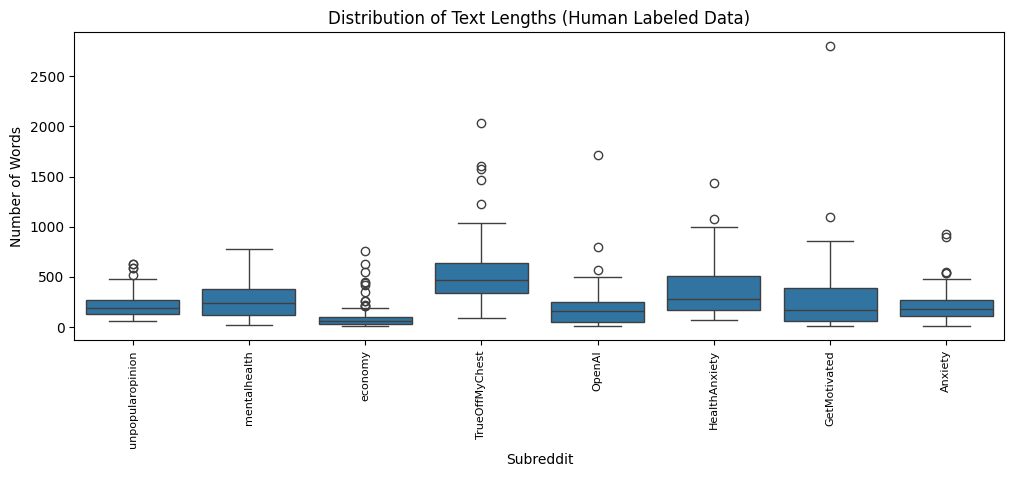

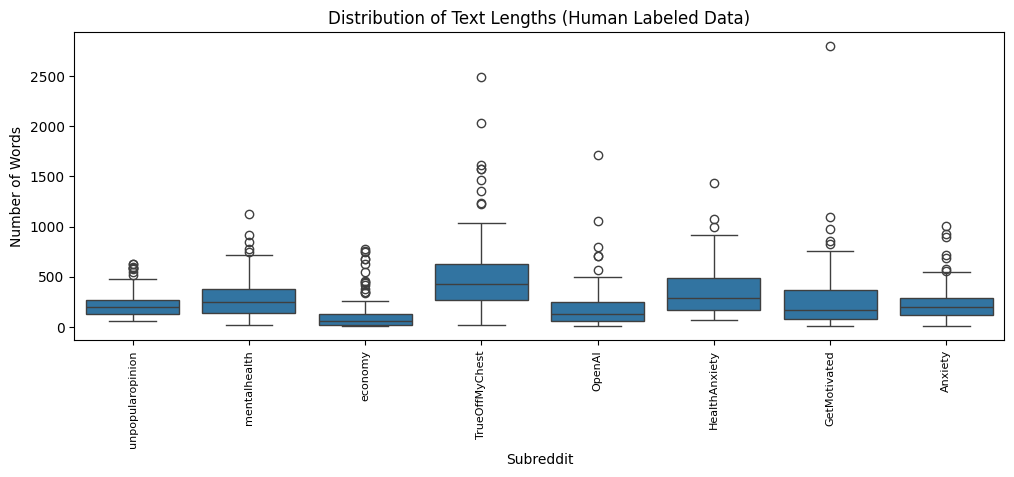

In [6]:
examine_text(human_label, 'text_all')
examine_text(ai_label, 'text_all')

Human-labeled dataset:


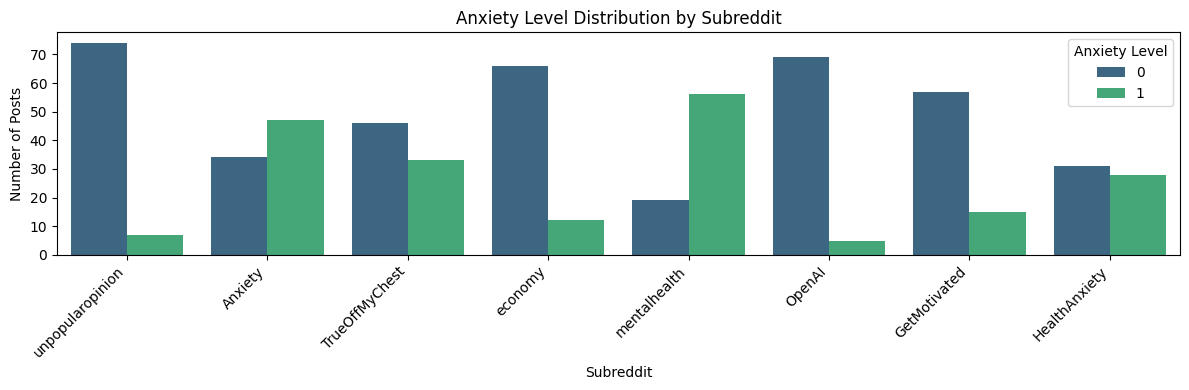

AI-labeled dataset:


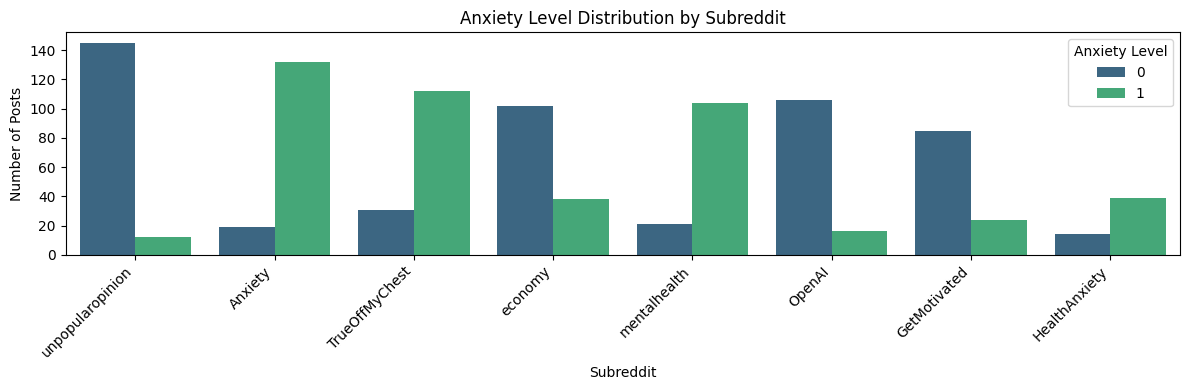

In [7]:
print("Human-labeled dataset:")
plot_anxiety_distribution_by_subreddit(df=human_label, subreddit_col="subreddit", anxiety_col="anxiety_level")
print("AI-labeled dataset:")
plot_anxiety_distribution_by_subreddit(df=ai_label, subreddit_col="subreddit", anxiety_col="anxiety_level")

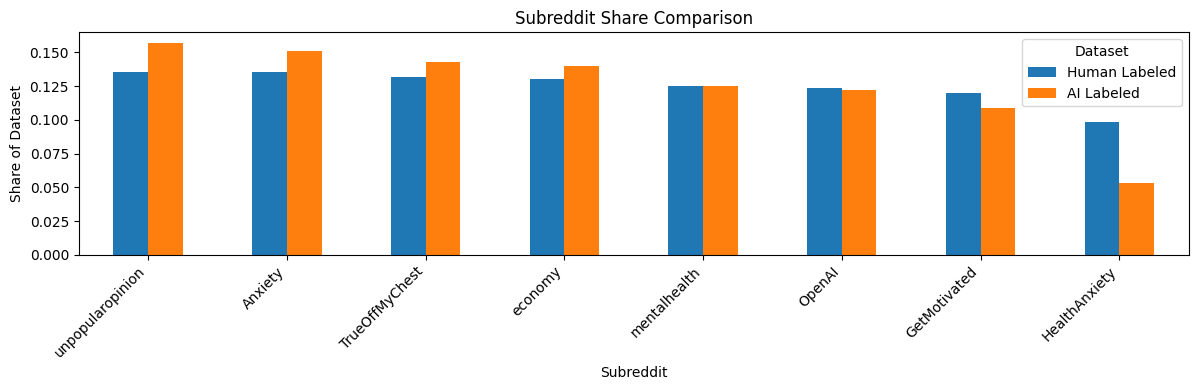

In [8]:
plot_subreddit_ratios(human_label, ai_label, label_left="Human Labeled", label_right="AI Labeled", top_n=20)

**Key Findings**
- **Text lengths** look similar across both datasets, with most posts under 500 words.
- **Anxiety-level distributions** differ sharply by subreddit—especially for Anxiety, TrueOffMyChest, and HealthAnxiety. That gap could reflect instability in the AI labels, inconsistency in human labels, or how annotators’ fatigue and personal biases creep in when reading long batches of anxiety-related posts. 
- **Different subreddit-to-total ratios** also matter: HealthAnxiety shows up far less often in the AI-labeled set than in the human-labeled set. Looking just at subreddit shares, HealthAnxiety has a markedly smaller presence in the AI-labeled data, while unpopularopinion, Anxiety, TrueOffMyChest, and economy appear slightly more often. Because overall metrics average across all posts, this kind of imbalance can make one dataset look stronger or weaker for reasons unrelated to true model performance.

## **4. Dataset Comparison**

**Purpose**: Build a fast baseline model to compare human labels with AI-generated labels.

In [9]:
os.environ.setdefault("TOKENIZERS_PARALLELISM", "true")
# Load tokenizer
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    pad_to_multiple_of=8 if torch.cuda.is_available() else None,
)

human_dataset = split_data(human_label, "anxiety_level", test_size=0.2, val_size=0.1, random_state=42)
ai_dataset = split_data(ai_label, "anxiety_level", test_size=0.2, val_size=0.1, random_state=42)

configs = [
    (human_dataset, "human_label"),
    (ai_dataset, "ai_label")
]

num_proc = max(1, min(os.cpu_count() or 1, 8))
tokenized_cache = {}
model_cache = {}

start_time = time.time()
df_list, metrics_result = [], []
print("Starting experiments...")

for dataset, dataset_name in configs:
    print(f"Testing {dataset_name}...")

    cache_key = (dataset_name)
    if cache_key not in tokenized_cache:
        map_kwargs = dict(
            batched=True,
            load_from_cache_file=True,
            desc=f"Tokenizing {dataset_name}",
        )
        if num_proc > 1:
            map_kwargs["num_proc"] = num_proc

        tokenized_dataset = dataset.map(partial(tokenize, text_col="text_all"), **map_kwargs)
        tokenized_dataset = tokenized_dataset.rename_column("anxiety_level", "labels")
        tokenized_dataset = tokenized_dataset.with_format("torch")
        tokenized_cache[cache_key] = tokenized_dataset
    else:
        tokenized_dataset = tokenized_cache[cache_key]

    num_labels = len(set(tokenized_dataset["train"]["labels"]))
    if num_labels not in model_cache:
        model_cache[num_labels] = DistilBertForSequenceClassification.from_pretrained(
            checkpoint, num_labels=num_labels
        )
    model = deepcopy(model_cache[num_labels])

    # simple args for quick testing
    args = TrainingArguments(
    output_dir=f".ipynb_checkpoints/distilbert_dataset_{dataset_name}",
    save_strategy="no",
    learning_rate=7e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.0,
    logging_strategy="no",
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    metrics = trainer.evaluate(tokenized_dataset["test"])

    df_list.append(dataset_name)
    metrics_result.append(metrics)

total_time = time.time() - start_time
print(f"Total time for all experiments: {total_time:.2f} seconds")

metrics_df = pd.DataFrame(metrics_result)
metrics_df["dataset"] = df_list
metrics_df = metrics_df[
    ["dataset"]
    + [col for col in metrics_df.columns if col not in {"dataset"}]
]
display(metrics_df)

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Starting experiments...
Testing human_label...


Tokenizing human_label (num_proc=8):   0%|          | 0/431 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing human_label (num_proc=8):   0%|          | 0/48 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing human_label (num_proc=8):   0%|          | 0/120 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Setting TOKENIZERS_PARALLELISM=false for forked processes.


Testing ai_label...


Tokenizing ai_label (num_proc=8):   0%|          | 0/720 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing ai_label (num_proc=8):   0%|          | 0/80 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing ai_label (num_proc=8):   0%|          | 0/200 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Total time for all experiments: 440.17 seconds


,dataset,eval_loss,eval_accuracy,eval_f1_weighted,eval_precision_weighted,eval_recall_weighted,eval_roc_auc,eval_average_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,human_label,2.705281,0.658333,0.522697,0.433403,0.658333,0.769991,0.613153,14.1836,8.460,0.282,1.0
1,ai_label,1.898472,0.800000,0.799520,0.809394,0.800000,0.880602,0.868940,17.1120,11.688,0.409,1.0


## **5. Ablation Testing on Stop Words**

**Purpose**: Using Customized Stop Words with TF-IDF generated Stop Words as the baseline pipeline, then systematically remove pieces (drop TF-IDF, then drop stop words) while keeping everything else fixed and compare the resulting performance.

**Key Finding** 
- The AI-labeled runs outperform the human-labeled runs on every metric we tracked:
    - Higher accuracy (0.80 vs 0.66), 
    - Weighted F1 (0.80 vs 0.52), 
    - ROC AUC at 0.88 vs 0.77
    - Average Precision at 0.87 vs 0.61. 
    - This points to AI annotations being either cleaner or more in tune with DistilBERT’s inductive bias.
- Given that consistent lift, we’ll move forward using the AI-labeled dataset for the enhanced training pipeline.

In [10]:
import sys
sys.path.append("../src") 

import text_processing_functions as tp
start_time = time.time()
print("Extracting stop words...")
_, _, stopwords_tfidf = tp.process_text_fordistilBERT(
    "\n\n".join(raw_data["text_all"].astype(str)),
    tfidf=True,
    return_stopwords=True,
)

_, _, stopwords = tp.process_text_fordistilBERT(
     "\n\n".join(raw_data["text_all"].astype(str)),
    tfidf=False,
    return_stopwords=True,
)


print("Preprocessing text...")
ai_label["text_all_processed"] = (
    ai_label["text_all"]
    .fillna("")
    .apply(lambda doc: tp.process_text(doc, extra_stopwords=stopwords))
    .apply(lambda toks: " ".join(toks))
)
ai_label["text_all_processed_tfidf"] = (
    ai_label["text_all"]
    .fillna("")
    .apply(lambda doc: tp.process_text_tfidf(doc, extra_stopwords=stopwords))
    .apply(lambda toks: " ".join(toks))
)


print(f"Data preprocessing time: {time.time() - start_time:.2f} seconds")
print(f"Loaded {len(ai_label):,} submissions")
ai_label.head(2)

Extracting stop words...
Preprocessing text...
Data preprocessing time: 76.18 seconds
Loaded 1,000 submissions


,subreddit,text_all,anxiety_level,text_all_processed,text_all_processed_tfidf
244,unpopularopinion,"no, tour fave animation/cartoon would not have...",0,tour fave anim cartoon better children network...,anim titl state everi aim kid air cartoonnetwo...
728,unpopularopinion,the real cause of the cost of living crisis is...,0,real caus cost live crisi fiat monetari someon...,real caus live crisi monetari someon someon ha...


In [11]:
comparing_dict = [
    ("TF-IDF Stop Words", "text_all_processed_tfidf",),
    ("Stop Words", "text_all_processed",),
    ("No Stop Words", "text_all"),
]

num_proc = max(1, min(os.cpu_count() or 1, 8))
tokenized_cache = {}
model_cache = {}

start_time = time.time()
stop_word_list, metrics_result = [], []
print("Starting experiments...")

for stop_words_name, text_col in comparing_dict:
    print(f"Testing {stop_words_name}...")

    ai_dataset_processed = split_data(ai_label, "anxiety_level", test_size=0.2, val_size=0.1, random_state=42)

    cache_key = (stop_words_name)
    if cache_key not in tokenized_cache:
        map_kwargs = dict(
            batched=True,
            load_from_cache_file=True,
            desc=f"Tokenizing {stop_words_name}",
        )
        if num_proc > 1:
            map_kwargs["num_proc"] = num_proc

        tokenized_dataset = ai_dataset_processed.map(partial(tokenize, text_col=text_col), **map_kwargs)
        tokenized_dataset = tokenized_dataset.rename_column("anxiety_level", "labels")
        tokenized_dataset = tokenized_dataset.with_format("torch")
        tokenized_cache[cache_key] = tokenized_dataset
    else:
        tokenized_dataset = tokenized_cache[cache_key]

    num_labels = len(set(tokenized_dataset["train"]["labels"]))
    if num_labels not in model_cache:
        model_cache[num_labels] = DistilBertForSequenceClassification.from_pretrained(
            checkpoint, num_labels=num_labels
        )
    model = deepcopy(model_cache[num_labels])

    # simple args for quick testing
    args = TrainingArguments(
    output_dir=f".ipynb_checkpoints/distilbert_stopwords_{stop_words_name}",
    save_strategy="no",
    learning_rate=7e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.0,
    logging_strategy="no",
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    metrics = trainer.evaluate(tokenized_dataset["test"])

    stop_word_list.append(stop_words_name)
    metrics_result.append(metrics)

total_time = time.time() - start_time
print(f"Total time for all experiments: {total_time:.2f} seconds")

metrics_df = pd.DataFrame(metrics_result)
metrics_df["stop_word"] = stop_word_list
metrics_df = metrics_df[
    ["stop_word"]
    + [col for col in metrics_df.columns if col not in {"stop_word"}]
]
display(metrics_df)

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Starting experiments...
Testing TF-IDF Stop Words...


Tokenizing TF-IDF Stop Words (num_proc=8):   0%|          | 0/720 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing TF-IDF Stop Words (num_proc=8):   0%|          | 0/80 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing TF-IDF Stop Words (num_proc=8):   0%|          | 0/200 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Setting TOKENIZERS_PARALLELISM=false for forked processes.


Testing Stop Words...


Tokenizing Stop Words (num_proc=8):   0%|          | 0/720 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing Stop Words (num_proc=8):   0%|          | 0/80 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing Stop Words (num_proc=8):   0%|          | 0/200 [00:00<?, ? examples/s]

Step,Training Loss


Setting TOKENIZERS_PARALLELISM=false for forked processes.


Testing No Stop Words...


Tokenizing No Stop Words (num_proc=8):   0%|          | 0/720 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing No Stop Words (num_proc=8):   0%|          | 0/80 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing No Stop Words (num_proc=8):   0%|          | 0/200 [00:00<?, ? examples/s]

Step,Training Loss


Total time for all experiments: 672.84 seconds


,stop_word,eval_loss,eval_accuracy,eval_f1_weighted,eval_precision_weighted,eval_recall_weighted,eval_roc_auc,eval_average_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,TF-IDF Stop Words,1.841260,0.61,0.55650,0.672180,0.61,0.701654,0.688436,14.0586,14.226,0.498,1.0
1,Stop Words,1.914606,0.53,0.37256,0.752010,0.53,0.740551,0.733555,18.0171,11.101,0.389,1.0
2,No Stop Words,1.898472,0.80,0.79952,0.809394,0.80,0.880602,0.868940,15.6868,12.750,0.446,1.0


**Key Finding**
- TF-IDF-augmented stop list lands at 60% accuracy/F1≈0.54, so the model struggles to separate classes. 
- Plain stop words only drops further to 53% accuracy with heavily imbalanced predictions (precision high because it sticks to one label). 
- No-stop-word preprocessing gives 80% accuracy and weighted F1 almost 0.80, plus the strongest ROC-AUC and average precision.

**Conclusion**\
We will use **No Stop Words** preprocessing because it provides the highest accuracy (0.80), best weighted F1 (~0.80), strongest ROC-AUC and average precision, and balanced precision/recall—so the model predicts both classes well without discarding potentially informative tokens.

## **6. Hyperparameter Tuning**

**Purpose**: Improve models' performance by hyperparameter tuning.

In [12]:
# using cached tokenized dataset and model to do final training
tokenized_dataset = tokenized_cache[("No Stop Words")]
model = deepcopy(model_cache[len(set(tokenized_dataset["train"]["labels"]))])

# Due to limited time and computation capacity, we only try 3 sets of hyperparameters
epochs_list = [5, 3, 2]
learning_rate_list = [1e-4, 3e-5, 5e-5]
weight_decay_list = [0.01, 0.03, 0.05]

use_cuda_fp16 = torch.cuda.is_available()


epoch_result, learning_rate_result, weight_decay_result, metrics_result = [], [], [], []
start_time = time.time()
for i in range(len(epochs_list)):
    epochs = epochs_list[i]
    lr = learning_rate_list[i]
    wd = weight_decay_list[i]
    print(f"Training with epochs={epochs}, lr={lr}, weight_decay={wd}")
    args = TrainingArguments(
        output_dir=f".ipynb_checkpoints/distilbert_hyperparam_{i}",
        save_strategy="epoch",
        learning_rate=lr,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=epochs,
        weight_decay=wd,
        logging_strategy="epoch",
        fp16=use_cuda_fp16
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    trainer.save_model(args.output_dir)
    tokenizer.save_pretrained(args.output_dir)
    metrics = trainer.evaluate(tokenized_dataset["test"])
    epoch_result.append(epochs)
    learning_rate_result.append(lr)
    weight_decay_result.append(wd)
    metrics_result.append(metrics)

total_time = time.time() - start_time
print(f"Total time for hyperparameter tuning: {total_time:.2f} seconds")

metrics_comparison = pd.DataFrame(metrics_result)
metrics_comparison["epochs"] = epoch_result
metrics_comparison["learning_rate"] = learning_rate_result
metrics_comparison["weight_decay"] = weight_decay_result
metrics_comparison = metrics_comparison[
    ["epochs", "learning_rate", "weight_decay"]
    + [col for col in metrics_comparison.columns if col not in {"epochs", "learning_rate", "weight_decay"}]
]
display(metrics_comparison)

Training with epochs=5, lr=0.0001, weight_decay=0.01


Step,Training Loss
45,2.237600
90,0.472000
135,0.290200
180,0.130700
225,0.047700


Training with epochs=3, lr=3e-05, weight_decay=0.03


Step,Training Loss
45,0.050100
90,0.034200
135,0.028100


Training with epochs=2, lr=5e-05, weight_decay=0.05


Step,Training Loss
45,0.073300
90,0.020900


Total time for hyperparameter tuning: 2060.54 seconds


,epochs,learning_rate,weight_decay,eval_loss,eval_accuracy,eval_f1_weighted,eval_precision_weighted,eval_recall_weighted,eval_roc_auc,eval_average_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,5,0.00010,0.01,0.676881,0.825,0.825109,0.826250,0.825,0.918797,0.924937,16.9286,11.814,0.414,5.0
1,3,0.00003,0.03,0.944471,0.830,0.829898,0.835800,0.830,0.927268,0.931781,19.6021,10.203,0.357,3.0
2,2,0.00005,0.05,1.021022,0.830,0.829762,0.837721,0.830,0.928020,0.930515,16.3620,12.223,0.428,2.0


**Key Findings**
- Configuration #1 (5 epochs, lr=1e-4, weight decay=0.01) shows lower eval loss but slightly worse discriminative ability, suggesting it may be slightly over-calibrated or less confident in positive predictions.
- Configuration #2 (3 epochs, lr = 3e-5, weight decay = 0.03) achieves the best ranking metrics (highest ROC-AUC = 0.927, AP = 0.930), meaning it most effectively separates classes and retrieves positives. Although its evaluation loss is slightly higher than Config #1, this indicates only a small difference in probability calibration—not a meaningful drop in predictive quality.
- Configuration #3 (2 epochs, lr=5e-5, weight decay=0.05) underperforms both, showing higher loss and no gain in metrics despite stronger regularization (weight decay = 0.05).

**Conclusion**
- Configuration #2 is recommended. It delivers the best overall discriminative performance (highest ROC-AUC and AP) while maintaining solid accuracy and F1. The small trade-off in evaluation loss is acceptable, as ranking metrics better capture real-world performance for imbalanced or nuanced classification tasks.

## **7. Training Data Comparison**

**Purpose**: Compare model's performance with different training size ratio.

In [20]:
training_size = [0.3, 0.5, 0.7, 0.9]
metrics_result = []
num_proc = max(1, min(os.cpu_count() or 1, 8))
use_cuda_fp16 = torch.cuda.is_available()

start_time = time.time()

for size in training_size:
    print(f"Training size fraction: {size}")
    dataset = split_data(ai_label, "anxiety_level", test_size=(1-size), val_size=0.1, random_state=42)

    tokenized_dataset = dataset.map(partial(tokenize, text_col="text_all"), **map_kwargs)
    tokenized_dataset = tokenized_dataset.rename_column("anxiety_level", "labels")
    tokenized_dataset = tokenized_dataset.with_format("torch")
    
    num_labels = len(set(tokenized_dataset["train"]["labels"]))
    if num_labels not in model_cache:
        print('non')
        model_cache[num_labels] = DistilBertForSequenceClassification.from_pretrained(
            checkpoint, num_labels=num_labels
        )
    model = deepcopy(model_cache[num_labels])
    
    args = TrainingArguments(
        output_dir=f".ipynb_checkpoints/distilbert_hyperparam_{size}",
        save_strategy="epoch",
        learning_rate=3e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=3,
        weight_decay=0.03,
        logging_strategy="epoch",
        fp16=use_cuda_fp16
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    trainer.save_model(args.output_dir)
    tokenizer.save_pretrained(args.output_dir)
    metrics = trainer.evaluate(tokenized_dataset["test"])
    metrics_result.append(metrics)

total_time = time.time() - start_time
print(f"Total time for hyperparameter tuning: {total_time:.2f} seconds")

metrics_comparison = pd.DataFrame(metrics_result)
metrics_comparison["training_size_fraction"] = training_size
metrics_comparison = metrics_comparison[["training_size_fraction"] + list(metrics_comparison.columns[:-1])]
display(metrics_comparison)

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Training size fraction: 0.3


Tokenizing No Stop Words (num_proc=8):   0%|          | 0/270 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing No Stop Words (num_proc=8):   0%|          | 0/30 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing No Stop Words (num_proc=8):   0%|          | 0/700 [00:00<?, ? examples/s]

Step,Training Loss
17,4.649200
34,3.288500
51,2.760000


Setting TOKENIZERS_PARALLELISM=false for forked processes.


Training size fraction: 0.5


Tokenizing No Stop Words (num_proc=8):   0%|          | 0/450 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing No Stop Words (num_proc=8):   0%|          | 0/50 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing No Stop Words (num_proc=8):   0%|          | 0/500 [00:00<?, ? examples/s]

Step,Training Loss
29,4.594400
58,2.681400
87,2.018700


Setting TOKENIZERS_PARALLELISM=false for forked processes.


Training size fraction: 0.7


Tokenizing No Stop Words (num_proc=8):   0%|          | 0/629 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing No Stop Words (num_proc=8):   0%|          | 0/70 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing No Stop Words (num_proc=8):   0%|          | 0/301 [00:00<?, ? examples/s]

Step,Training Loss
40,4.412800
80,2.116200
120,1.305400


Training size fraction: 0.9


Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing No Stop Words (num_proc=8):   0%|          | 0/810 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing No Stop Words (num_proc=8):   0%|          | 0/90 [00:00<?, ? examples/s]

Setting TOKENIZERS_PARALLELISM=false for forked processes.


Tokenizing No Stop Words (num_proc=8):   0%|          | 0/100 [00:00<?, ? examples/s]

Step,Training Loss
51,4.228300
102,1.601200
153,0.811600


Total time for hyperparameter tuning: 2314.79 seconds


,training_size_fraction,eval_loss,eval_accuracy,eval_f1_weighted,eval_precision_weighted,eval_recall_weighted,eval_roc_auc,eval_average_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.3,2.598697,0.782857,0.781247,0.786554,0.782857,0.850103,0.823552,75.6573,9.252,0.291,3.0
1,0.5,1.829228,0.696000,0.665627,0.776730,0.696000,0.854962,0.842865,57.5484,8.688,0.278,3.0
2,0.7,1.137707,0.820598,0.820598,0.820598,0.820598,0.882519,0.882159,39.8438,7.555,0.251,3.0
3,0.9,0.634632,0.870000,0.870039,0.871645,0.870000,0.945112,0.951194,10.5634,9.467,0.379,3.0


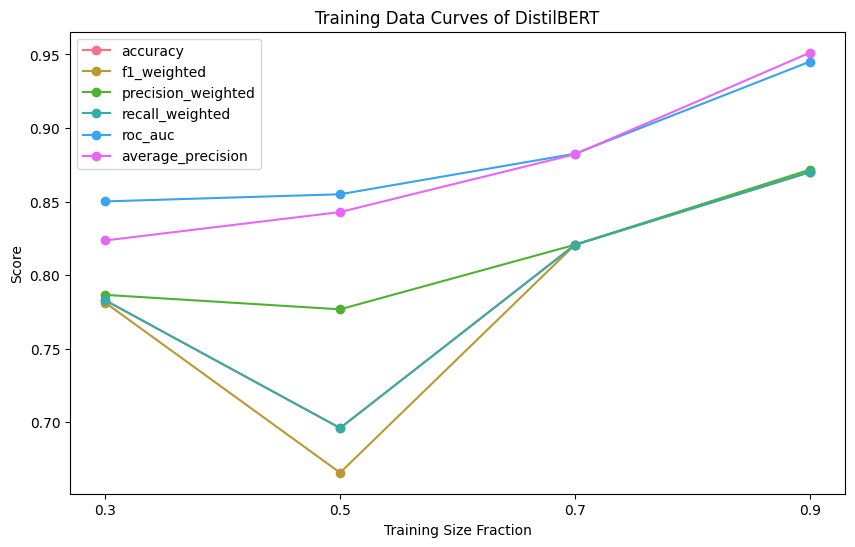

In [21]:
metrics_list = ["accuracy", "f1_weighted", "precision_weighted", "recall_weighted", "roc_auc", "average_precision"]
color_list = sns.color_palette("husl", len(metrics_list))

plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics_list):
    plt.plot(metrics_comparison['training_size_fraction'], metrics_comparison['eval_'+metric], marker='o', label=metric, color=color_list[i])
plt.title('Training Data Curves of DistilBERT', fontsize=12)
plt.xlabel('Training Size Fraction', fontsize=10)
plt.ylabel('Score', fontsize=10)
plt.xticks(training_size)
plt.legend()

**Key Finding**
- **30% train split**: Model is learning basic patterns but still has high error; underfitting due to limited data.
- **50% train split**: Accuracy actually drops, suggesting noise or imbalance in the extra data; model unstable.
- **70% train split**: Clear improvement—loss drops and ranking metrics rise; model benefits from broader training coverage.
- **90% train split**: Strongest overall performance—loss lowest, accuracy and AUC highest; model generalizes better with more data.

**Conclusion**
- Adding more data continues to benefit the model. The metrics demonstrates steady performance gains up to 90% of the training data—lower loss, higher accuracy, and stronger ranking metrics. The model is not yet saturated, meaning additional high-quality data could still improve generalization and stability.

## **8. Conclusion, Limitation and Future Work**
**Conclusion**
- We compared the human-labeled and AI-labeled datasets and found that the AI-labeled data offered better performance, with ROC-AUC = 0.88 and AP = 0.87, indicating some inconsistency issues within the human-labeled dataset.
- We conducted an ablation test on stop-word removal and found that using no stop words produced the best performance (ROC-AUC = 0.88, AP = 0.87), suggesting that DistilBERT performs better with raw, unprocessed text.
- We performed hyperparameter tuning and found that Configuration #2 (epochs = 3, learning rate = 3e-5, weight decay = 0.03) achieved the best performance, with ROC-AUC = 0.927 and AP = 0.93.
- Finally, we tested different training data fractions and observed that the model can be benefited by adding more data.

**Limitations**
- Subreddit imbalance persists: communities like HealthAnxiety appear far less in the AI-labeled data, so the model sees uneven exposure. That imbalance likely skews both evaluation and real-world predictions toward the dominant subreddits.
- Annotation noise is uneven: AI- and human-labeled posts show different labeling quirks, and training on a single source risks inheriting its specific biases. We currently have limited understanding of how label errors propagate through the pipeline.
- Scope of hyperparameter search is narrow: only three combinations of epochs, learning rate, and weight decay were explored, so the chosen configuration may not be optimal.

**Future Work**
- Balance subreddit representation via stratified sampling, weighted loss functions, or targeted data augmentation to reduce bias toward heavily represented communities.
- Blend or adjudicate labels using both AI and human annotations, possibly introducing human-in-the-loop checks on the noisiest subreddits to curb source-specific bias.
- Expand hyperparameter and architecture searches, including layer freezing, dropout, learning-rate schedules, and batch-size sweeps—and consider ensemble methods to tighten performance bounds.
- This notebook was designed to run on Great Lakes to take advantage of faster computation, but incompatible package imports blocked that plan. With limited time we left the issue unresolved; given more runway, fixing the environment would let us exploit that extra compute for deeper hyperparameter sweeps, cross-validation, and subgroup-specific evaluations that could further improve model performance.